## 0. Import module and Load Data

In [130]:
#  데이터 처리 모듈
import pandas as pd
from sklearn.impute import KNNImputer
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# 행렬 등 통계 연산 모듈
import numpy as np
from scipy.stats import iqr
# 지수형 표기법 e를 연속형 변환
pd.options.display.float_format = '{:.4f}'.format
# 타입 어노테이션(Any, Sequence 등의 메서드 활용)
from typing import *
import os
# pd.set_option('display.max_seq_items',None)
# pd.set_option('display.max_rows',None)

# 구글 드라이브 마운트
from google.colab import drive
drive.mount("/content/drive")
import os

# 조합 찾는 반복문 메서드
from itertools import permutations
from itertools import combinations

# 데이터 시각화
import matplotlib.pyplot as plt
# from matplotlib.pyplot import
import matplotlib.font_manager as fm
import missingno as msno
import seaborn as sns

pd.set_option('display.max_seq_items',None)

# 모델링 메서드
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

# 회귀 모델
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

# 하이퍼 파라미터 튜닝
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [118]:
# apt-get : 패키지 설치 명령어
# -qq : 에러외의 메세지 숨기는 옵션키
!apt-get -qq install fonts-nanum

fe = fm.FontEntry(
    fname=r"/usr/share/fonts/truetype/nanum/NanumGothic.ttf",
    # ttf 파일이 저장되어 있는 경로
    name='NanumGothic')
# 이 폰트의 원하는 이름 설정
fm.fontManager.ttflist.insert(0, fe)
# Matplotlib에 폰트 추가
plt.rcParams.update({'font.size': 18, 'font.family': 'NanumGothic'})
# 폰트 설정

Selecting previously unselected package fonts-nanum.
(Reading database ... 120895 files and directories currently installed.)
Preparing to unpack .../fonts-nanum_20200506-1_all.deb ...
Unpacking fonts-nanum (20200506-1) ...
Setting up fonts-nanum (20200506-1) ...
Processing triggers for fontconfig (2.13.1-4.2ubuntu5) ...


In [2]:
class LoadGoogleDriveData():
  def __init__(self, data = None):
    self.data = data

  def loadData(self, file_path: str, file_name_extension,
               columnTF: bool, unicode: str) -> pd.DataFrame():
    self.data = pd.read_csv(os.path.join(file_path + file_name_extension),
                            index_col = columnTF,
                            na_values = "NaN",
                            encoding = unicode)
    return self.data

  # 용량이 큰 csv 파일 읽어오기(fopen - fread와 유사한 방식)
  def loadDataWithChunking(self, file_path: str, file_name_extension,
                           chunking_row_num: int, columnTF: bool, unicode: str) -> pd.DataFrame():
    chunkdata = pd.read_csv(os.path.join(file_path + file_name_extension),
                            chunksize = chunking_row_num,
                            index_col = columnTF,
                            na_values = "NaN",
                            encoding = unicode)
    self.data = list(chunkdata)
    self.data = pd.concat(self.data)

    return self.data

In [3]:
mountInstance = LoadGoogleDriveData()

In [101]:
KCD_MARKET_CONTEST_SEASON_2022_TOTAL = mountInstance.loadData(
    file_path = "/content/drive/MyDrive/2023BigContest/data/total data/", file_name_extension = "KCD_MARKET_CONTEST_SEASON_2022_TOTAL.csv",
    unicode = "utf-8-sig", columnTF = False)

KCD_MARKET_CONTEST_SEASON_2023_TOTAL = mountInstance.loadData(
    file_path = "/content/drive/MyDrive/2023BigContest/data/total data/", file_name_extension = "KCD_MARKET_CONTEST_SEASON_2023_TOTAL.csv",
    unicode = "utf-8-sig", columnTF = False)

y_pred_2301 = mountInstance.loadData(
    file_path = "/content/drive/MyDrive/2023BigContest/data/total data/", file_name_extension = "y_pred_2301.csv",
    unicode = "utf-8-sig", columnTF = False)

CONTEST_2023_FEATURE = pd.read_csv("/content/drive/MyDrive/2023BigContest/data/CONTEST_2023_FEATURE.csv", index_col = False)

CONTEST_2023 = pd.read_excel('/content/drive/MyDrive/2023BigContest/data/contest data/소상공인 매출등급 예상 대상 필지.xlsx')

## 1. 기본 데이터 모델링 성능 확인
- 2022년 데이터로 훈련 및 검증

In [102]:
# 업종코드 수치형 변한
KCD_MARKET_CONTEST_SEASON_2022_TOTAL['INDUSTRY_CD'] = KCD_MARKET_CONTEST_SEASON_2022_TOTAL['INDUSTRY_CD'].str[1:].astype('int64')
KCD_MARKET_CONTEST_SEASON_2023_TOTAL['INDUSTRY_CD'] = KCD_MARKET_CONTEST_SEASON_2023_TOTAL['INDUSTRY_CD'].str[1:].astype('int64')

In [103]:
# 데이터 분할
X = KCD_MARKET_CONTEST_SEASON_2022_TOTAL.drop(columns = ['매출등급x로짓추정확률'])
y = KCD_MARKET_CONTEST_SEASON_2022_TOTAL['매출등급x로짓추정확률']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### 1-1. 선형회귀 모델링

In [104]:
# 선형회귀 모델 생성 및 학습
model = LinearRegression()
model.fit(X_train, y_train)

# 학습된 모델을 사용하여 예측
y_pred = model.predict(X_test).round().astype(int)

# 회귀 모델 평가
mse = mean_squared_error(y_test, y_pred)  # 평균 제곱 오차
print("평균 제곱 오차 (MSE):", mse)

평균 제곱 오차 (MSE): 2.6593294087535195


### 1-2. 의사결정나무 모델링

In [105]:
# 모델 생성 및 학습
model = DecisionTreeRegressor()
model.fit(X_train, y_train)

# 학습된 모델을 사용하여 예측
y_pred = model.predict(X_test)

# 회귀 모델 평가
mse = mean_squared_error(y_test, y_pred)  # 평균 제곱 오차
print("평균 제곱 오차 (MSE):", mse)

평균 제곱 오차 (MSE): 2.369743887388164


### 1-3. 랜덤포레스트 모델링

In [106]:
# 모델 생성 및 학습
model = RandomForestRegressor()
model.fit(X_train, y_train)

# 학습된 모델을 사용하여 예측
y_pred = model.predict(X_test)

# 회귀 모델 평가
mse = mean_squared_error(y_test, y_pred)  # 평균 제곱 오차
print("평균 제곱 오차 (MSE):", mse)

평균 제곱 오차 (MSE): 1.9044783932962526


## 2. 2단계 모델링

- 22년 1월 ~ 22년 12월 데이터로 학습 => 23년 1월 매출등급 예측
- 최종 23년 1월 매출등급 예측값 = 23년 1월 매출등급 예측값 * 1월_매출등급_로짓추정확률_주성분

<img src = 'https://drive.google.com/uc?id=1qdrednUyVO60UYaX1s7XnW-XqwBC-jDC'>

In [107]:
# 23년 1월 매출등급 예측

## 데이터 분할
X_train = KCD_MARKET_CONTEST_SEASON_2022_TOTAL.drop(columns = ['매출등급x로짓추정확률']) # 22년1월~12월 feature
y_train = KCD_MARKET_CONTEST_SEASON_2022_TOTAL['매출등급x로짓추정확률'] # 22년1월~12월 target(매출등급)
X_test = KCD_MARKET_CONTEST_SEASON_2023_TOTAL.drop(columns = ['SLS_GRD_2301','SLS_GRD_2302']) # 23년1월 feature

## 랜덤포레스트 모델 생성 및 학습
model = RandomForestRegressor()
model.fit(X_train, y_train)

## 학습된 모델을 사용하여 예측
y_pred_2301 = model.predict(X_test)
y_pred_2301 = pd.DataFrame({'SLS_GRD_2301_pred':y_pred_2301})
y_pred_2301['SLS_GRD_2301_pred'] = y_pred_2301['SLS_GRD_2301_pred'].round().astype(int)

## 예측된 1월 매출등급에 1월_매출등급_로짓추정확률_주성분를 곱해준다.
pred_2301 = pd.concat([pd.DataFrame(y_pred_2301),CONTEST_2023_FEATURE['1월_매출등급_로짓추정확률_주성분']*1000],axis=1)
pred_2301['SLS_GRD_2301_pred'] = pred_2301['SLS_GRD_2301_pred'] * pred_2301['1월_매출등급_로짓추정확률_주성분']
pred_2301 = pred_2301.dropna()

def transform_value(value):
    if value < 2:
        return 1
    elif value < 3:
        return 2
    elif value < 4:
        return 3
    elif value < 5:
        return 4
    else:
        return 5

pred_2301['SLS_GRD_2301_pred'] = pred_2301['SLS_GRD_2301_pred'].apply(transform_value)
pred_2301 = pred_2301['SLS_GRD_2301_pred']

print('23년 1월 매출등급 예측')
y_pred_2301[:5]

23년 1월 매출등급 예측


,SLS_GRD_2301_pred
0,3
1,3
2,2
3,3
4,3


- 22년 1월 ~ 23년 1월 데이터로 학습(23년 1월 예측값 포함) => 23년 2월 매출등급 예측
- 최종 23년 2월 매출등급 예측값 = 23년 2월 매출등급 예측값 * 2월_매출등급_로짓추정확률_주성분

In [108]:
# 23년 2월 매출등급 예측
## 데이터 분할
X_train_22 = KCD_MARKET_CONTEST_SEASON_2022_TOTAL.drop(columns = ['매출등급x로짓추정확률']) # 22년1월~12월 feature
#KCD_MARKET_CONTEST_SEASON_2301 = KCD_MARKET_CONTEST_SEASON_2023_TOTAL[KCD_MARKET_CONTEST_SEASON_2023_TOTAL['DATA_CRTR_YM'] == 20231]
X_train_23 = KCD_MARKET_CONTEST_SEASON_2023_TOTAL.drop(columns = ['SLS_GRD_2301', 'SLS_GRD_2302']) # 23년1월 feature

y_train_22 = pd.DataFrame(KCD_MARKET_CONTEST_SEASON_2022_TOTAL['매출등급x로짓추정확률']).rename(columns = {'매출등급x로짓추정확률':'SLS_GRD'}) # 22년1월~12월 target
y_train_2301 = y_pred_2301.rename(columns = {'SLS_GRD_2301_pred':'SLS_GRD'}) # 23년1월 target

#KCD_MARKET_CONTEST_SEASON_2302 = KCD_MARKET_CONTEST_SEASON_2023_TOTAL[KCD_MARKET_CONTEST_SEASON_2023_TOTAL['DATA_CRTR_YM'] == 20232]
X_test_23 = KCD_MARKET_CONTEST_SEASON_2023_TOTAL.drop(columns = ['SLS_GRD_2301', 'SLS_GRD_2302']) # 23년2월 feature

X_train = pd.concat([X_train_22,X_train_23],axis=0)
y_train = pd.concat([y_train_22,y_train_2301],axis=0)
X_test = X_test_23

## 랜덤포레스트 모델 생성 및 학습
model = RandomForestRegressor()
model.fit(X_train, y_train)

## 학습된 모델을 사용하여 예측
y_pred_2302 = model.predict(X_test)
y_pred_2302 = pd.DataFrame(y_pred_2302).rename(columns = {0:'SLS_GRD_2302_pred'})
y_pred_2302['SLS_GRD_2302_pred'] = y_pred_2302['SLS_GRD_2302_pred'].round().astype(int)

## 예측된 1월 매출등급에 1월_매출등급_로짓추정확률_주성분를 곱해준다.
pred_2302 = pd.concat([pd.DataFrame(y_pred_2302),CONTEST_2023_FEATURE['2월_매출등급_로짓추정확률_주성분']*1000],axis=1)
pred_2302['SLS_GRD_2302_pred'] = pred_2302['SLS_GRD_2302_pred'] * pred_2302['2월_매출등급_로짓추정확률_주성분']
pred_2302 = pred_2302.dropna()

pred_2302['SLS_GRD_2302_pred'] = pred_2302['SLS_GRD_2302_pred'].apply(transform_value)
pred_2302 = pred_2302['SLS_GRD_2302_pred']

print('23년 2월 매출등급 예측')
y_pred_2302[:5]

<ipython-input-108-9fde6012b714>:19: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train, y_train)


23년 2월 매출등급 예측


,SLS_GRD_2302_pred
0,3
1,3
2,2
3,3
4,3


- 피쳐 중요도 시각화

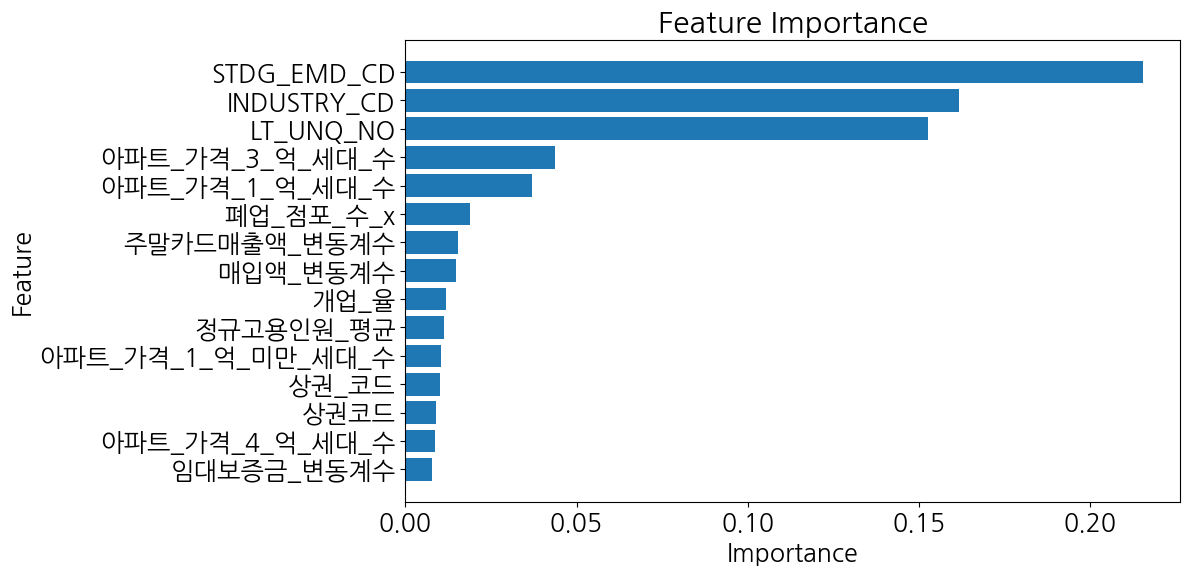

In [120]:
# Feature Importance 추출
feature_importances = model.feature_importances_

# 특성명과 함께 데이터프레임 생성
feature_importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': feature_importances})

# 피처 중요도를 내림차순으로 정렬
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)[:15]

# 피처 중요도 시각화
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance')
plt.gca().invert_yaxis()  # 중요도가 높은 피처가 위로 오도록 순서 뒤집기
plt.show()

### 4. 답안지 생성

In [132]:
# 답안지 제작
CONTEST_2023['SLS_GRD_2301'] = y_pred_2301['SLS_GRD_2301_pred']
CONTEST_2023['SLS_GRD_2302'] = y_pred_2302['SLS_GRD_2302_pred']
CONTEST_2023_ANSWER = CONTEST_2023
CONTEST_2023_ANSWER.tail(5)
CONTEST_2023_ANSWER.to_csv('CONTEST_2023_ANSWER.csv',encoding='utf-8-sig',index=False)

,LT_UNQ_NO,INDUSTRY_CD,STDG_EMD_CD,SLS_GRD_2301,SLS_GRD_2302
9995,1130510100100830004,A03,11305101,2,2
9996,1135010300107450000,A13,11350103,3,3
9997,1150010300103400017,A06,11500103,2,2
9998,1144012700116070000,A03,11440127,2,2
9999,1126010400100770063,A03,11260104,3,3
